This project is the final assignment of "**Belajar Machine Learning untuk Pemula**" course by Dicoding

by  [Satria Kemal Prawira](https://www.dicoding.com/users/codesigma)


# Preparation

Import necessary libraries

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import backend as K
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
import cv2
from google.colab import drive, files
import os
import numpy as np

Connect colab with google drive

In [2]:
dir = '/content/drive/My Drive/rockpaperscissors'

In [3]:
drive.mount('/content/drive/')
os.chdir(dir)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Modelling


Preview and resize sample image

(200, 300, 3)
(100, 150, 3)


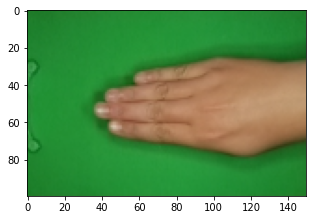

In [4]:
#get image size from dataset
img = load_img('./Train/paper/0cb6cVL8pkfi4wF6.png')  # this is a PIL image
x = img_to_array(img)
print(x.shape)
plt.figure(figsize=(5,5))
x = cv2.resize(x, (150, 100))
print(x.shape)
plt.imshow(x/255)

Build data generator, auto labelling images based on the directory

In [5]:
# train_datagen = ImageDataGenerator()
train_datagen = ImageDataGenerator( #Some little augmentations
    rescale=1./255,
    rotation_range=0.5, 
    shear_range=0.2,
    validation_split = 0.4 #40% of the data will be used as validation set
    # zoom_range=0.5,
    )


In [6]:
train_generator = train_datagen.flow_from_directory(
        './Train', 
        batch_size=32,
        shuffle=True,
        target_size = (x.shape[0], x.shape[1]),
        class_mode='categorical',
        subset='training')  
        

validation_generator = train_datagen.flow_from_directory(
        './Train', 
        batch_size=32,
        shuffle=True,
        target_size = (x.shape[0], x.shape[1]),
        class_mode='categorical',
         subset='validation')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


Additional metrics, just in case

In [7]:

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


Building model architecture

In [8]:

#C(64, 64, 128), FCN(128, 128)
initializer = tf.keras.initializers.GlorotUniform()

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(x.shape[0], x.shape[1], 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,  kernel_initializer=initializer,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128,  kernel_initializer=initializer,))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(optimizer='adam', #Using Adam Optimizer
              loss="categorical_crossentropy",   
              metrics=["accuracy",precision_m, recall_m])


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 148, 32)       896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 148, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 98, 148, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 72, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 72, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 47, 72, 32)        0

In [10]:
#make model folder model
model._name = "rockpaperscissors_CNN"
model_save_path = "./models/"
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

Callbacks

In [11]:
#Save the best model only

epochs = 30
checkpoint = ModelCheckpoint(os.path.join(model_save_path, model.name+".h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')


# reduceLR = ReduceLROnPlateau(monitor='val_accuracy',
#                                             patience=2,
#                                             verbose=1,
#                                             factor=0.5,
#                                             min_lr=0.000003)

In [12]:
#Terminates training when vall_acc > 96%
class TerminateOnBaseline(Callback):
    """Callback that terminates training when val_acc reaches a specified baseline
    """
    def __init__(self, monitor='val_accuracy', baseline=0.96):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [13]:
%%time
#training the model
history = model.fit(
        train_generator,
        steps_per_epoch = int(train_generator.samples) // 32,
        validation_data = validation_generator,
        epochs = epochs,
        callbacks=[checkpoint, TerminateOnBaseline()])

Epoch 1/30
41/41 [==============================] - 753s 18s/step - loss: 0.5917 - accuracy: 0.7617 - precision_m: 0.7880 - recall_m: 0.7309 - val_loss: 2.0007 - val_accuracy: 0.3318 - val_precision_m: 0.3237 - val_recall_m: 0.3237

Epoch 00001: val_accuracy improved from -inf to 0.33181, saving model to ./models/rockpaperscissors_CNN.h5
Epoch 2/30
41/41 [==============================] - 44s 1s/step - loss: 0.0966 - accuracy: 0.9816 - precision_m: 0.9856 - recall_m: 0.9757 - val_loss: 3.1741 - val_accuracy: 0.3318 - val_precision_m: 0.3310 - val_recall_m: 0.3310

Epoch 00002: val_accuracy did not improve from 0.33181
Epoch 3/30
41/41 [==============================] - 44s 1s/step - loss: 0.1165 - accuracy: 0.9691 - precision_m: 0.9706 - recall_m: 0.9648 - val_loss: 3.9078 - val_accuracy: 0.3318 - val_precision_m: 0.3359 - val_recall_m: 0.3359

Epoch 00003: val_accuracy did not improve from 0.33181
Epoch 4/30
41/41 [==============================] - 44s 1s/step - loss: 0.1255 - accurac

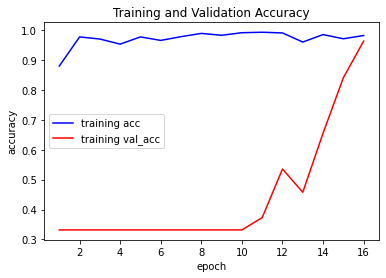

In [14]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, acc, color="blue", label="training acc")
plt.plot(epochs, val_acc, color="red", label="training val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

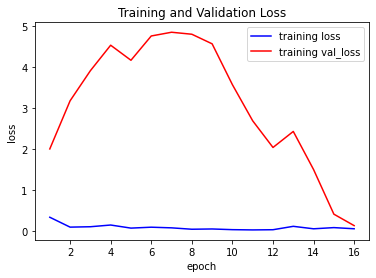

In [15]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, loss, color="blue", label="training loss")
plt.plot(epochs, val_loss, color="red", label="training val_loss")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss")

plt.show()

# Prediction

Saving 2vwLOZSd8FCXbuck.png to 2vwLOZSd8FCXbuck (10).png
Hmmm... this is a Rock!


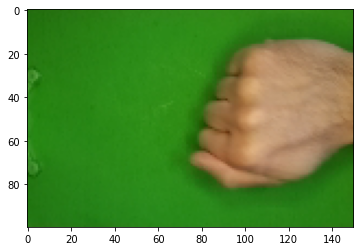

In [16]:

uploaded = files.upload()

filename = list(uploaded.keys())[0]

img = load_img(f"{dir}/{filename}", target_size=(x.shape[0], x.shape[1]))
plt.imshow(img)
img = img_to_array(img)

img = np.expand_dims(img, axis=0)/255

images = np.vstack([img])
classes = model.predict(images)
classes = classes.tolist()[0]
# print(classes)
label = classes.index(max(classes))
# print(label)
if label == 2:
  label = "Scissors"
elif label == 1:
  label = "Rock"
else:
  label = "Paper"

# print(label)

print(f"Hmmm... this is a {label}!")

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

In [18]:
# cv2.imread(imgtest)

In [19]:
# imgtest = cv2.resize(imgtest, (150, 100))
# model.predict(imgtest)

In [20]:
# from subprocess import call

In [21]:
# listdir = call(["ls"])
# listdir

In [22]:
# listdir = os.listdir(f"{dir}/Train")
# listdir

# for curr in listdir:
#   images = os.listdir(f"{dir}/Test/{curr}")
#   idx = 1
#   for img in images[0:int(len(images))]:
#     print(f"{idx}/{int(len(images))}: Moving {dir}/Test/{curr}/{img} to {dir}/Train/{curr} ")
#     call(["mv", f"{dir}/Test/{curr}/{img}", f"{dir}/Train/{curr}"])


#     idx+=1

